In [1]:
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from experiments.bayesianSelectionVariable.utils import get_tgt_log_density
from variational.exponential_family import GenericBernoulliDistributionNumpy as GenericBernoulliDistribution

PKLs = []
PKL_titles = []
for file in os.listdir("./"):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(file, "rb")))
        PKL_titles.append(str(file))

bernoulli = GenericBernoulliDistribution(dimension=92)

data = pd.read_csv('../concrete_from_particles.csv', header=None, delimiter=",")
obs = np.array(data.iloc[:, 0].to_numpy())
reg = np.array(data.iloc[:, 1:].to_numpy())
dim = reg.shape[1]
tgt_log_density = get_tgt_log_density(reg, obs)


In [2]:
selected_idx = [0, 1, 2]
min_probas = np.min([bernoulli.get_p(PKLs[idx]['res'][-1][:-1]) for idx in selected_idx], axis=0)
max_probas = np.max([bernoulli.get_p(PKLs[idx]['res'][-1][:-1]) for idx in selected_idx], axis=0)
mean_probas = np.mean([bernoulli.get_p(PKLs[idx]['res'][-1][:-1]) for idx in selected_idx], axis=0)
np.savetxt('min_probs.csv', min_probas)
np.savetxt('max_probs.csv', max_probas)
np.savetxt('mean_probas.csv', mean_probas)

In [3]:
def id(sample):
        return int(str((sample).astype(int)).replace("\n", "").replace(" ", "")[1:-1])
def construct_smc_empirical_measure(samples):
    N = samples.shape[0]
    weights_dict = dict()
    for sample in samples:
        _id = id(sample)
        if _id in weights_dict.keys():
            weights_dict[_id]+=1
        else:
            weights_dict[_id]=1
    for key in weights_dict.keys():
        weights_dict[key]/=N
    return weights_dict
    

    
PKLs_SMC = []
for file in os.listdir("../output_SMC/"):
    if file.endswith(".pkl"):
        PKLs_SMC.append(pickle.load(open("../output_SMC/" + file, "rb")))
max_probas_SMC = np.max([np.mean(PKLs_SMC[0][i]['output'].X.theta, axis=0) for i in range(3)], axis=0)
min_probas_SMC = np.min([np.mean(PKLs_SMC[0][i]['output'].X.theta, axis=0) for i in range(3)], axis=0)
mean_probas_SMC = np.mean([np.mean(PKLs_SMC[0][i]['output'].X.theta, axis=0) for i in range(3)], axis=0)


samples_from_SMC = np.concatenate([PKLs_SMC[0][i]['output'].X.theta for i in range(3)], axis=0)
my_empirical_distribution_smc = construct_smc_empirical_measure(samples_from_SMC)

def q_smc(sample):
    return my_empirical_distribution_smc[id(sample)]

def vect_q_smc(samples):
    return np.vectorize(q_smc, signature="(n)->()")(samples)


def score(p, samples):
    lq = np.log(p) * samples + np.log(1 - p) * (1 - samples)
    lq = np.nan_to_num(lq)
    s = tgt_log_density(samples) - np.sum(lq, axis=-1)
    return s

In [11]:
bins = np.linspace(-5760, -5530, 100)
theta_SMC = bernoulli.get_theta(mean_probas_SMC)
my_sampled_models_SMC = bernoulli.sampling_method_numpy(theta_SMC, 100000)
scores_iii = score(mean_probas_SMC, my_sampled_models_SMC)
plt.hist(scores_iii, bins, label="iii)", density=True)

theta = bernoulli.get_theta(mean_probas)
my_sampled_models = bernoulli.sampling_method_numpy(theta, 100000)
scores_ii = score(mean_probas, my_sampled_models)
plt.hist(scores_ii, bins, label="ii)", alpha=0.5,  density=True)

#samples_from_SMC = samples_from_SMC[np.random.choice(samples_from_SMC.shape[0], 100000)]
integrand_smc = tgt_log_density(samples_from_SMC)-np.log(vect_q_smc(samples_from_SMC))
plt.hist(integrand_smc, bins, label="SMC", alpha=0.5, density=True)

vector = np.ones(dim) * 0.5
vector[-1] = 1.0
theta = bernoulli.get_theta(vector)
my_sampled_models = bernoulli.sampling_method_numpy(theta, 10000)
scores_i = score(vector, my_sampled_models)
plt.hist(scores_i, bins, label="i)", alpha=0.5, density=True)
plt.legend(loc='upper right')
plt.savefig('histo_loss.png')

/tmp/ipykernel_1675/727318686.py:38: RuntimeWarning: divide by zero encountered in log
  lq = np.log(p) * samples + np.log(1 - p) * (1 - samples)
/tmp/ipykernel_1675/727318686.py:38: RuntimeWarning: invalid value encountered in multiply
  lq = np.log(p) * samples + np.log(1 - p) * (1 - samples)


KeyboardInterrupt: 

In [26]:
int(str((PKLs_SMC[0][0]['output'].X.theta[0]).astype(int)).replace("\n", "").replace(" ", "")[1:-1])

11110010000100000000000101000110000000001000000100000000000011011010011000000110111010000001

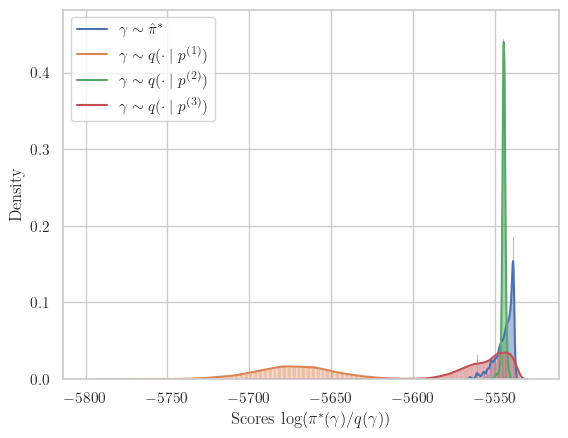

In [13]:
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True

for d in [integrand_smc, scores_i, scores_ii, scores_iii]:
    sns.histplot(d[d>=-5800], ax=ax, common_norm=True, common_bins=True, kde=True, binrange=(-5800, -5525), stat="density")
ax.legend([r'$\displaystyle \gamma\sim \hat{\pi}^*$', r'$\displaystyle \gamma\sim q(\cdot\mid p^{(1)})$', r'$\displaystyle \gamma\sim q(\cdot\mid p^{(2)})$', r'$\displaystyle \gamma\sim q(\cdot\mid p^{(3)})$'], facecolor="white")

plt.xlabel(r'Scores $\displaystyle \log(\pi^*(\gamma)/q(\gamma))$')
fig.savefig("histo_loss_kde.pdf", dpi=300)

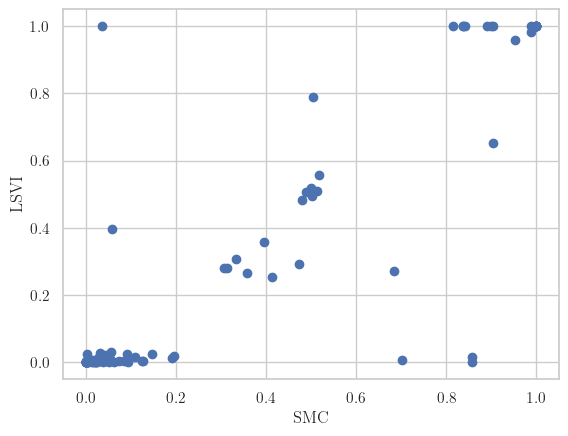

In [15]:
plt.scatter(mean_probas_SMC, mean_probas)
plt.savefig("scatter.png")

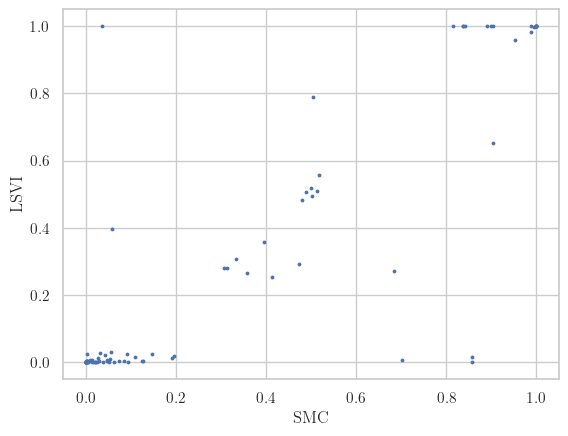

In [21]:
plt.scatter(mean_probas_SMC, mean_probas, s=3)
plt.xlabel("SMC")
plt.ylabel("LSVI")
plt.savefig("scatter_plot.pdf", dpi=300)


In [ ]:
r'$\displaystyle \gamma\sim q(\cdot\mid p^{(1)})', r'$\displaystyle \gamma\sim q(\cdot\mid p^{(2)})', r'$\displaystyle \gamma\sim q(\cdot\mid p^{(3)})'